### 1. Import Libraries

In [61]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
import optuna

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Import metrics
from sklearn.metrics import (
    f1_score,
    confusion_matrix,
    cohen_kappa_score,
    precision_score,
    recall_score,
    balanced_accuracy_score,
    roc_auc_score
)

# Import LabelEncoder for encoding categorical variables
from sklearn.preprocessing import LabelEncoder, RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns

import time

### 2. Import processed data

In [2]:
df = pd.read_csv('../processed_data/openfoodfacts_processed.csv')

In [3]:
df["nutriscore_grade"].value_counts()

nutriscore_grade
c    130818
d    116119
a     94114
e     73175
b     66723
Name: count, dtype: int64

### 3. Use RobustScaler to scale the numerical columns

In [4]:
scaler = RobustScaler()
numerical_columns =  ["energy-kcal_100g", "sugars_100g", "saturated-fat_100g", "salt_100g", "fat_100g", "fiber_100g", "proteins_100g"]

# Robust scalling
robust_df = scaler.fit_transform(df[numerical_columns])
robust_df = pd.DataFrame(robust_df, columns=numerical_columns)

# Drop numerical columns
df = df.drop(columns=numerical_columns)

# Merge the two dataframes
df = pd.concat([df, robust_df], axis=1)

In [5]:
df.head()

,product_name,categories_en,ingredients_text,nutriscore_grade,food_groups_en,main_category_en,countries_en,energy-kcal_100g,sugars_100g,saturated-fat_100g,salt_100g,fat_100g,fiber_100g,proteins_100g
0,Poulet fermier,Clean-antioxidant-energy-drink,Mandeln blanchiert,b,NaN,Clean-antioxidant-energy-drink,France,-0.539007,0.230375,-0.168067,-0.475821,-0.297152,-0.231884,-0.465296
1,Poulet fermier,Clean-antioxidant-energy-drink,Mandeln blanchiert,b,NaN,Clean-antioxidant-energy-drink,Germany,-0.539007,0.230375,-0.168067,-0.475821,-0.297152,-0.231884,-0.465296
2,Poulet fermier,Clean-antioxidant-energy-drink,Mandeln blanchiert,b,NaN,Clean-antioxidant-energy-drink,United States,-0.539007,0.230375,-0.168067,-0.475821,-0.297152,-0.231884,-0.465296
3,California Whole Pitted Prunes,"Beverages and beverages preparations,Beverages...","california dried pitted plums, potassium sorbate",c,"Beverages,Unsweetened beverages",Sample,Germany,0.177305,2.883959,-0.280112,-0.565373,-0.343341,1.710145,-0.401028
4,NaN,"Beverages and beverages preparations,Beverages...",NaN,c,NaN,Cinnamon-roll,Germany,0.106383,-0.232082,0.280112,0.379900,0.503464,2.144928,2.105398


### 4. Use LabelEncoder to encode categorical columns

In [6]:
categorical_columns = ["countries_en", "food_groups_en", "nutriscore_grade"]
label_encoders = {}
for column in categorical_columns:
    print(len(df[column].unique()), column)
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

df.head()

96 countries_en
46 food_groups_en
5 nutriscore_grade


,product_name,categories_en,ingredients_text,nutriscore_grade,food_groups_en,main_category_en,countries_en,energy-kcal_100g,sugars_100g,saturated-fat_100g,salt_100g,fat_100g,fiber_100g,proteins_100g
0,Poulet fermier,Clean-antioxidant-energy-drink,Mandeln blanchiert,1,45,Clean-antioxidant-energy-drink,26,-0.539007,0.230375,-0.168067,-0.475821,-0.297152,-0.231884,-0.465296
1,Poulet fermier,Clean-antioxidant-energy-drink,Mandeln blanchiert,1,45,Clean-antioxidant-energy-drink,30,-0.539007,0.230375,-0.168067,-0.475821,-0.297152,-0.231884,-0.465296
2,Poulet fermier,Clean-antioxidant-energy-drink,Mandeln blanchiert,1,45,Clean-antioxidant-energy-drink,90,-0.539007,0.230375,-0.168067,-0.475821,-0.297152,-0.231884,-0.465296
3,California Whole Pitted Prunes,"Beverages and beverages preparations,Beverages...","california dried pitted plums, potassium sorbate",2,7,Sample,30,0.177305,2.883959,-0.280112,-0.565373,-0.343341,1.710145,-0.401028
4,NaN,"Beverages and beverages preparations,Beverages...",NaN,2,45,Cinnamon-roll,30,0.106383,-0.232082,0.280112,0.379900,0.503464,2.144928,2.105398


### 5. Select X and y columns

In [7]:
df = df.dropna()
df = df.reset_index(drop=True)

In [8]:
X = df[numerical_columns + categorical_columns].drop(columns="nutriscore_grade")
y = df["nutriscore_grade"]

### 6. Split data into full training and test set

In [9]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X,
    y,
    test_size=0.3,       # 20% test
    stratify=y,          # helps preserve class distribution if classes are imbalanced
    random_state=42
)

print("Full training set size:", X_train_full.shape)
print("Test set size:", X_test.shape)

Full training set size: (271842, 9)
Test set size: (116504, 9)


### 7. Splittng training data into a smaller subset of training data. Test set left untouched

In [10]:
train_subset_fraction = 0.15  # 15% of the training set

X_train_small, _, y_train_small, _ = train_test_split(
    X_train_full,
    y_train_full,
    train_size=train_subset_fraction,
    stratify=y_train_full,
    random_state=42
)

print("Downsampled training set size:", X_train_small.shape)

Downsampled training set size: (40776, 9)


### 8. Testing model baseline performance

In [11]:
def fit_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Calculate metrics
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    # Append results to the list
    performance_results = {
        "Model": model.__class__.__name__,
        "Train Time" : train_time,
        "Precision": precision,
        "Recall" : recall,
        "F1 Score (Weighted)": f1,
        "Cohen Kappa Score": kappa,
        "Balanced Accuracy": balanced_accuracy,
        "ROC AUC Score": roc_auc
    }

    return performance_results

In [12]:
models = [
    LogisticRegression(solver='liblinear', multi_class='ovr'),
    SVC(probability=True, class_weight='balanced'),
    RandomForestClassifier(),
    XGBClassifier(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    CatBoostClassifier(verbose=0),
    LGBMClassifier(verbose=0)
]

# Evaluate each model
baseline_performance_results = []
for model in models:
    print(50*'-', end='\n\n')
    print(f'Evaluating {model.__class__.__name__}...')
    try:
        baseline_performance_results.append(fit_and_evaluate_model(model, X_train_small, y_train_small, X_test, y_test))
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        break
    print("Successfully finished evaluation.", end='\n\n')
print(50*'-')



--------------------------------------------------

Evaluating LogisticRegression...
Successfully finished evaluation.

--------------------------------------------------

Evaluating SVC...
Successfully finished evaluation.

--------------------------------------------------

Evaluating RandomForestClassifier...
Successfully finished evaluation.

--------------------------------------------------

Evaluating XGBClassifier...
Successfully finished evaluation.

--------------------------------------------------

Evaluating KNeighborsClassifier...
Successfully finished evaluation.

--------------------------------------------------

Evaluating DecisionTreeClassifier...
Successfully finished evaluation.

--------------------------------------------------

Evaluating CatBoostClassifier...
Successfully finished evaluation.

--------------------------------------------------

Evaluating LGBMClassifier...
Successfully finished evaluation.

--------------------------------------------------


In [13]:
baseline_performance_results_df = pd.DataFrame(baseline_performance_results)

### 9. Baseline performance results

In [14]:
baseline_performance_results_df

,Model,Train Time,Precision,Recall,F1 Score (Weighted),Cohen Kappa Score,Balanced Accuracy,ROC AUC Score
0,LogisticRegression,0.232411,0.654753,0.643961,0.617680,0.539620,0.601423,0.878227
1,SVC,148.153023,0.603354,0.574736,0.570029,0.466668,0.572532,0.892937
2,RandomForestClassifier,3.809180,0.865642,0.866588,0.865315,0.829901,0.852997,0.978639
3,XGBClassifier,0.969411,0.869056,0.870185,0.869075,0.834608,0.856700,0.979806
4,KNeighborsClassifier,0.009427,0.755524,0.755141,0.754370,0.688277,0.743670,0.927271
5,DecisionTreeClassifier,0.144702,0.812430,0.811981,0.812188,0.761183,0.804565,0.879878
6,CatBoostClassifier,3.666162,0.871632,0.872588,0.871431,0.837624,0.858850,0.979994
7,LGBMClassifier,2.808882,0.867663,0.868820,0.867604,0.832832,0.855010,0.979113


### 10. Splitting performance results into 2 sets - metrics and time

In [15]:
baseline_performance_results_excl_time = baseline_performance_results_df.drop(columns="Train Time")
baseline_performance_training_time = baseline_performance_results_df[["Model", "Train Time"]]

In [16]:
# Unpivot df for plotting
baseline_performance_results_excl_time_unpivot = pd.melt(baseline_performance_results_excl_time, id_vars=["Model"], var_name="Metric", value_name="Score")

In [17]:
# models_aggregated_score_incl_time = baseline_performance_results_excl_time_unpivot.groupby("Model")["Score"].mean().sort_values(ascending=False)
models_aggregated_score = baseline_performance_results_excl_time_unpivot.groupby("Model")["Score"].mean().sort_values(ascending=False)

### 11. Visualizing Model Performance Comparison

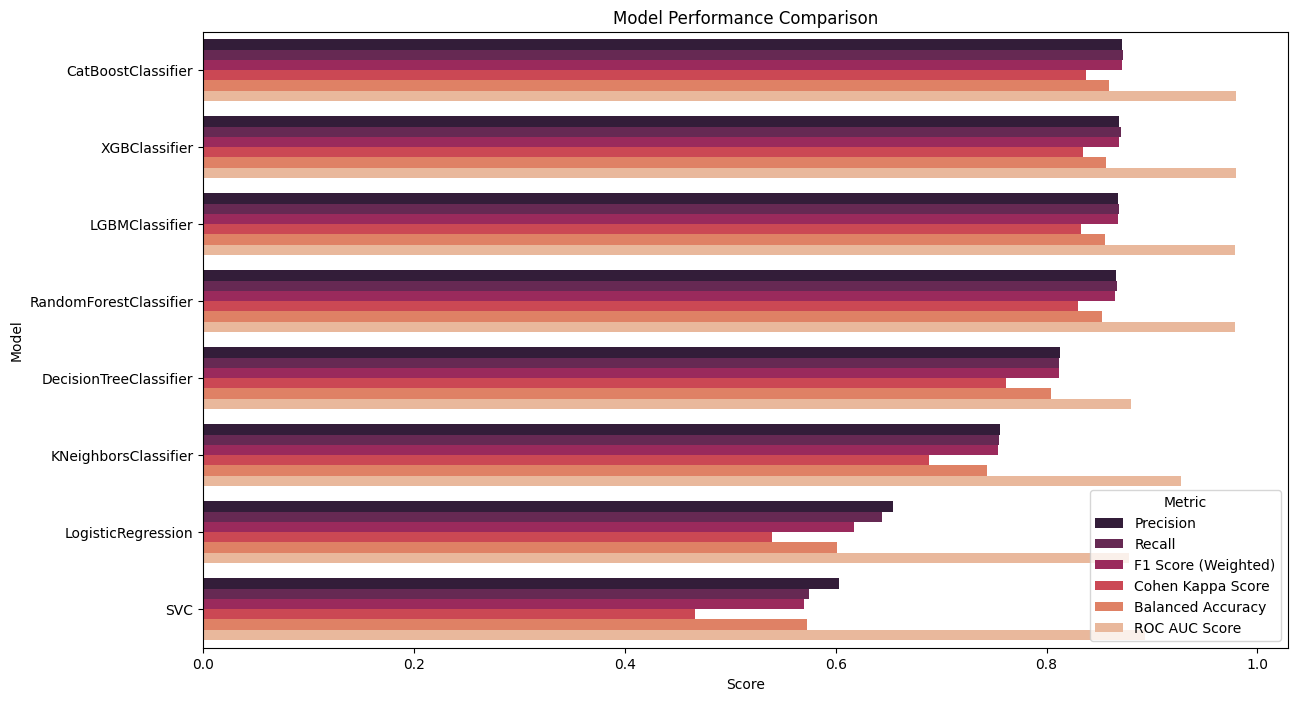

In [18]:
plt.figure(figsize=(14, 8))

bar = sns.barplot(
    x="Score", 
    y="Model", 
    hue="Metric", 
    data=baseline_performance_results_excl_time_unpivot, 
    palette="rocket", 
    order=models_aggregated_score.index,
    
)
plt.title("Model Performance Comparison")
plt.show()

### 12. Visualising Training Time of each model

In [19]:
baseline_performance_training_time = baseline_performance_training_time.sort_values(by="Train Time", ascending=False)

/var/folders/42/qb5wjq2s2tbb78brl4w4mbgh0000gn/T/ipykernel_2754/3194502676.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(


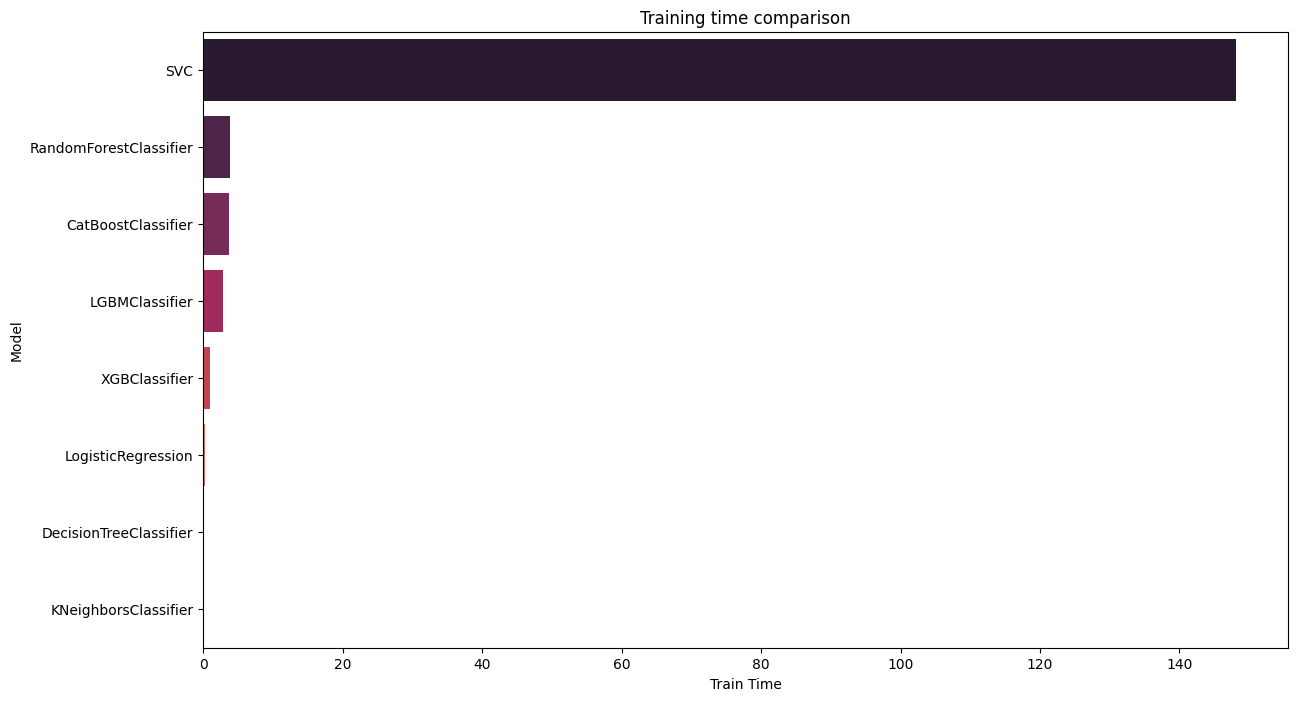

In [20]:
# Train time comparison
plt.figure(figsize=(14, 8))

bar = sns.barplot(
    x="Train Time", 
    y="Model",
    data=baseline_performance_training_time, 
    palette="rocket", 
    order=baseline_performance_training_time.Model,
    
)
plt.title("Training time comparison")
plt.show()

### 13. Determining initial parameters for best performing model using RandomSearch

While the baseline performance results were similar among the top four models, XGBClassifier had the best training time and was therefore chosen as the primary model for predicting the NutriScore grade.

In [33]:
xgb = XGBClassifier(n_jobs=4)

# Define hyperparameters grid
hyperparameters = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7], 
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 1],
        'reg_alpha': [0, 0.01],
        'reg_lambda': [1]
}

fine_tunning_results = []
k_fold_cv = 3

model_name = xgb.__class__.__name__
print(f"Fine-tunning {model_name}")

random_search = RandomizedSearchCV(
        xgb, 
        param_distributions=hyperparameters, 
        cv=k_fold_cv, 
        n_iter = 100, 
        scoring="f1_micro",
        verbose=0, 
        random_state=42,
        n_jobs=2,
        return_train_score=True
)

random_search.fit(X_train_small, y_train_small)

Fine-tunning XGBClassifier


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=4,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=100, n_jobs=2,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'gamma': [0, 1],
                                        'learning_rate': [0.01, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200],
                                        'reg_alpha': [0, 0.01],
                                        'reg_lambda': [1],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, return_train_score=True,
                   scoring='f1_micro')

In [34]:
model_for_random_search_best_params = {
    "Model Name": model_name,
    "Best Parameters": random_search.best_params_,
    "Best Score": random_search.best_score_,
    "Best Estimator": random_search.best_estimator_,
    "CV Results": random_search.cv_results_
}

In [35]:
random_search_performance_results = fit_and_evaluate_model(random_search.best_estimator_, X_train_small, y_train_small, X_test, y_test)

In [36]:
random_search_performance_results_df = pd.DataFrame([random_search_performance_results])

In [37]:
random_search_performance_results_df

,Model,Train Time,Precision,Recall,F1 Score (Weighted),Cohen Kappa Score,Balanced Accuracy,ROC AUC Score
0,XGBClassifier,1.182479,0.870705,0.871824,0.870624,0.836656,0.858278,0.980279


### 14. Display feature importance of XGBoost Classifier

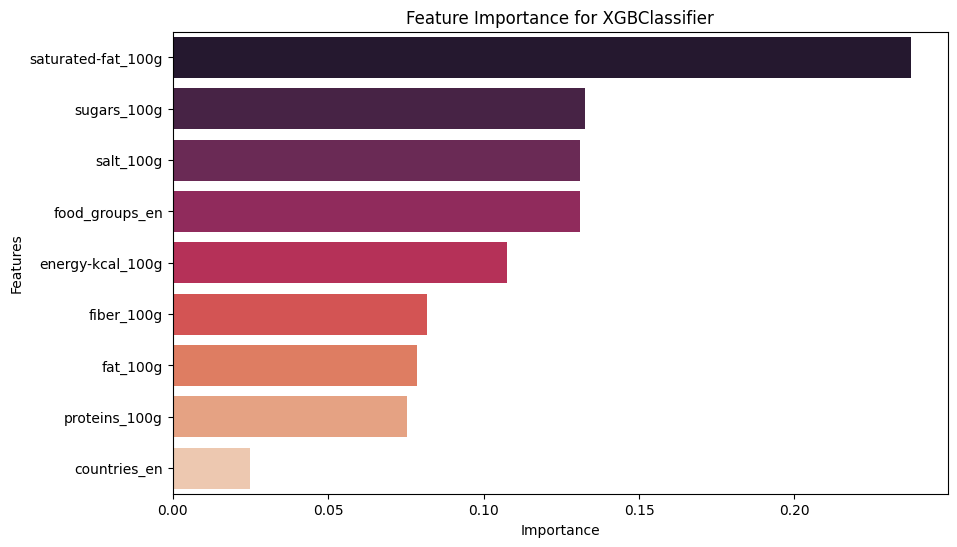

In [38]:
feature_columns = X_train_small.columns

# Extract feature importance and model name
feature_importances = model_for_random_search_best_params["Best Estimator"].feature_importances_
model_name = model_for_random_search_best_params["Model Name"]

# Create a DataFrame for easier manipulation and sorting
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x = importance_df['Importance'], y = importance_df['Feature'], hue = importance_df['Feature'], legend=False, palette='rocket')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title(f'Feature Importance for {model_name}')
plt.show()

In [39]:
models_cv_results = {}
name = model_for_random_search_best_params["Model Name"]
best_params = model_for_random_search_best_params["Best Parameters"]
results = model_for_random_search_best_params["CV Results"]

first_search_results = pd.DataFrame(results)
first_search_results = first_search_results.sort_values(by="rank_test_score")
first_search_results = first_search_results.head(20)
models_cv_results[name] = {
    "cv_results" : first_search_results,
    "best_params" : best_params
}

In [40]:
display(models_cv_results["XGBClassifier"]["cv_results"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_n_estimators,param_max_depth,param_learning_rate,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
72,1.717076,0.079581,0.053637,0.000620,0.8,1,0,200,7,0.1,...,0.863449,0.861463,0.863179,0.001306,1,0.958137,0.959278,0.957880,0.958431,0.000607
76,1.680064,0.060826,0.051518,0.000435,1.0,1,0,200,7,0.1,...,0.862272,0.863523,0.863130,0.000608,2,0.954348,0.953465,0.954900,0.954238,0.000591
23,1.103748,0.023892,0.053282,0.000397,0.8,1,0.01,200,7,0.1,...,0.862934,0.859550,0.860874,0.001476,3,0.932865,0.931835,0.932828,0.932509,0.000477
26,1.242939,0.091078,0.058108,0.000459,0.8,1,0,200,7,0.1,...,0.857637,0.856533,0.857882,0.001214,4,0.929186,0.927715,0.928083,0.928328,0.000625
92,0.925173,0.047907,0.039684,0.000915,1.0,1,0,200,7,0.1,...,0.854179,0.854179,0.854817,0.000902,5,0.920836,0.917672,0.918077,0.918862,0.001406
37,1.009752,0.053768,0.047099,0.001006,1.0,1,0.01,200,7,0.1,...,0.854768,0.853958,0.854326,0.000334,6,0.920836,0.920284,0.919254,0.920125,0.000656
67,0.742216,0.018943,0.035443,0.000749,0.8,1,0,100,7,0.1,...,0.854620,0.852781,0.853811,0.000767,7,0.914325,0.913552,0.913258,0.913711,0.000450
82,0.919962,0.089694,0.029771,0.000464,1.0,1,0,100,7,0.1,...,0.855503,0.852119,0.853713,0.001389,8,0.918960,0.919732,0.920063,0.919585,0.000462
38,1.035408,0.018623,0.028763,0.000220,0.8,1,0.01,200,5,0.1,...,0.854326,0.852707,0.853590,0.000669,9,0.908476,0.903546,0.905569,0.905864,0.002023
77,1.004321,0.036293,0.032727,0.000404,0.8,1,0.01,200,5,0.1,...,0.854473,0.849544,0.851898,0.002018,10,0.901339,0.899169,0.899242,0.899917,0.001006


In [41]:
models_cv_results["XGBClassifier"]["cv_results"].to_csv("../cv_results/xgb_cv_1_results.csv", index=False)

### 15. Performing another search with tuned parameters (based on top 20 search results from the previous step)

In [46]:
model_for_random_search_2 = XGBClassifier(n_jobs=4)

hyperparameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 6, 7, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.8, 0.9],
    'gamma': [0, 1, 2],
    'reg_alpha': [0, 0.001, 0.01, 0.05],
    'reg_lambda': [0.5, 1, 1.5]
}

k_fold_cv = 3

# Fine-tuning
model_name = model_for_random_search_2.__class__.__name__
print(f"Fine-tunning {model_name}")
random_search = RandomizedSearchCV(
    model_for_random_search_2, 
    param_distributions=hyperparameters, 
    cv=k_fold_cv, 
    n_iter = 100, 
    scoring="f1_micro",
    verbose=0, 
    random_state=42,
    n_jobs=1, 
    return_train_score=True
)


random_search.fit(X_train_small, y_train_small)

model_for_random_search_2_best_params = {
    "Model Name": model_name,
    "Best Parameters": random_search.best_params_,
    "Best Score": random_search.best_score_,
    "Best Estimator": random_search.best_estimator_,
    "CV Results": random_search.cv_results_
}


Fine-tunning XGBClassifier


In [47]:
model_name = model_for_random_search_2_best_params["Model Name"]
best_estimator = model_for_random_search_2_best_params["Best Estimator"]
best_params = model_for_random_search_2_best_params["Best Parameters"]

random_search_2_performance_results = fit_and_evaluate_model(best_estimator, X_train_small, y_train_small, X_test, y_test)

random_search_2_performance_results_df = pd.DataFrame([random_search_2_performance_results])

In [58]:
random_search_2_performance_results_df

,Model,Train Time,Precision,Recall,F1 Score (Weighted),Cohen Kappa Score,Balanced Accuracy,ROC AUC Score
0,XGBClassifier,2.264095,0.876858,0.877833,0.876942,0.844402,0.866032,0.982046


In [59]:
best_params

{'subsample': 0.8,
 'reg_lambda': 1,
 'reg_alpha': 0,
 'n_estimators': 200,
 'max_depth': 7,
 'learning_rate': 0.1,
 'gamma': 0,
 'colsample_bytree': 0.8}

### 16. Performing Baesian Optimization for optimal hyperparameter tuning

In [62]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [64]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }
    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train_small, y_train_small, cv=3, scoring='f1_weighted').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-01-31 01:19:05,972] A new study created in memory with name: no-name-62c97ab6-81e5-47b2-9609-0fddf96494d2
[I 2025-01-31 01:19:27,811] Trial 0 finished with value: 0.850263934602801 and parameters: {'learning_rate': 0.01978987646702702, 'max_depth': 11, 'n_estimators': 474, 'subsample': 0.821286997976628, 'colsample_bytree': 0.6970365570792643, 'gamma': 0.9895546317364096, 'reg_alpha': 1.1039774016433013, 'reg_lambda': 1.490075280481915, 'min_child_weight': 1}. Best is trial 0 with value: 0.850263934602801.
[I 2025-01-31 01:19:40,159] Trial 1 finished with value: 0.7959441771211352 and parameters: {'learning_rate': 0.01610710409446925, 'max_depth': 7, 'n_estimators': 397, 'subsample': 0.8112430438576709, 'colsample_bytree': 0.7076873541502091, 'gamma': 2.499818079742679, 'reg_alpha': 6.806387178374185, 'reg_lambda': 3.8243350865164945, 'min_child_weight': 9}. Best is trial 0 with value: 0.850263934602801.
[I 2025-01-31 01:19:43,221] Trial 2 finished with value: 0.803487947057457

In [65]:
best_model_evaluation = fit_and_evaluate_model(
    XGBClassifier(**study.best_params), 
    X_train_small, 
    y_train_small, 
    X_test, y_test
)

### 17. Visualize and compare results for each search

In [68]:
best_model_evaluation_results_df = pd.DataFrame([best_model_evaluation])
best_model_evaluation_results_df

,Model,Train Time,Precision,Recall,F1 Score (Weighted),Cohen Kappa Score,Balanced Accuracy,ROC AUC Score
0,XGBClassifier,4.301538,0.874098,0.875155,0.874169,0.840967,0.862536,0.981532


In [69]:
performance_results = {
    "Baseline Performance": baseline_performance_results_df.loc[
        baseline_performance_results_df["Model"] == "XGBClassifier"
    ],
    "1st random search": random_search_performance_results_df,
    "2nd random search": random_search_2_performance_results_df,
    "Optuna": best_model_evaluation_results_df,
}

# Add the keys as a column to each DataFrame and concatenate
performance_results_df = pd.concat(
    [df.assign(Search_Type=key) for key, df in performance_results.items()],
    ignore_index=True
)

# Display the resulting DataFrame
performance_results_df = performance_results_df.drop(columns="Train Time")
performance_results_df


,Model,Precision,Recall,F1 Score (Weighted),Cohen Kappa Score,Balanced Accuracy,ROC AUC Score,Search_Type
0,XGBClassifier,0.869056,0.870185,0.869075,0.834608,0.856700,0.979806,Baseline Performance
1,XGBClassifier,0.870705,0.871824,0.870624,0.836656,0.858278,0.980279,1st random search
2,XGBClassifier,0.876858,0.877833,0.876942,0.844402,0.866032,0.982046,2nd random search
3,XGBClassifier,0.874098,0.875155,0.874169,0.840967,0.862536,0.981532,Optuna


In [70]:
performance_results_df_unpivot = performance_results_df.drop(columns="Model")
performance_results_df_unpivot = pd.melt(performance_results_df_unpivot, id_vars=["Search_Type"], var_name="Metric", value_name="Score")

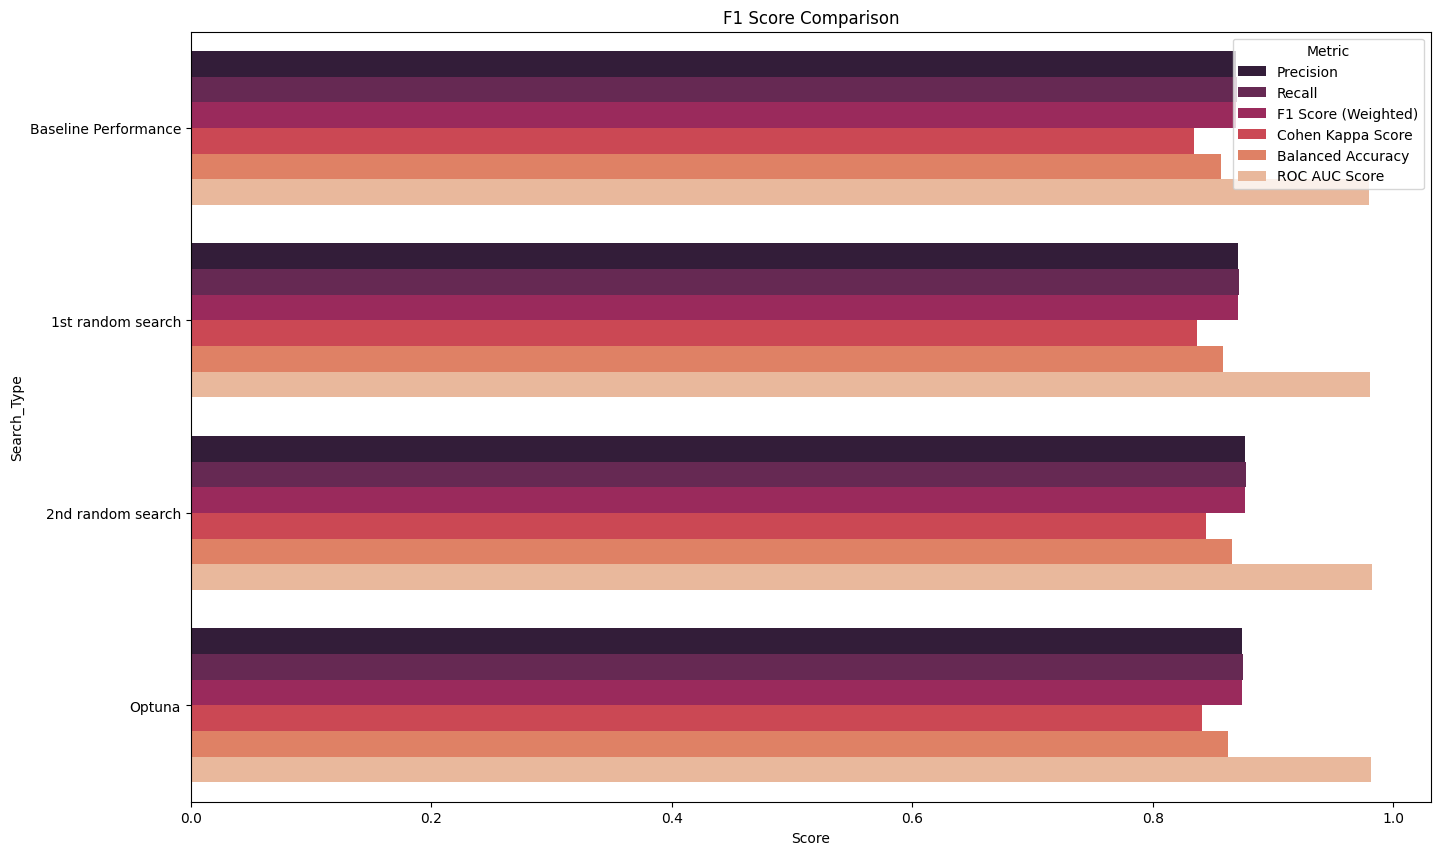

In [71]:
plt.figure(figsize=(16, 10))
sns.barplot(
    performance_results_df_unpivot,
    x = "Score", 
    y = "Search_Type",
    hue = "Metric", 
    palette="rocket"
)
plt.title("F1 Score Comparison")
plt.show()

### 17. Fit final model with full training data

In [72]:
final_model = XGBClassifier(**best_params)
final_model.fit(X_train_full, y_train_full)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [73]:
final_model_evaluation = fit_and_evaluate_model(final_model, X_train_full, y_train_full, X_test, y_test)

In [74]:
final_model_evaluation_results_df = pd.DataFrame([final_model_evaluation])
final_model_evaluation_results_df

,Model,Train Time,Precision,Recall,F1 Score (Weighted),Cohen Kappa Score,Balanced Accuracy,ROC AUC Score
0,XGBClassifier,3.966757,0.893207,0.893952,0.892862,0.864871,0.881134,0.985358


In [75]:
confusion_matrix(y_test, final_model.predict(X_test))

array([[21009,  1276,   654,     2,     1],
       [ 2289, 11097,  2332,    39,     7],
       [  683,  1249, 28537,   994,    95],
       [   17,    56,  1039, 26576,   556],
       [    4,    35,   395,   632, 16930]])

In [76]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "../model/nutriscore_grade_prediction_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)